In [1]:
from src.data_transforms import *
from src.image_loader import ImageLoader
# from src.esfpnet import ESFPNetStructure
from src.trainer_cross import *
import torch
import os
from torch.utils.data import DataLoader, random_split
import torch
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
torch.cuda.empty_cache()

%load_ext autoreload
%autoreload 2

In [2]:
root_dir = os.getcwd()
num_epochs = 10

# Initialization

Initialize the trainer class.

In [3]:
runner = Trainer(model_name='unet',
                 model_dir=os.path.join(root_dir, 'src'),
                 train_data_transforms=get_train_transforms(),
                 val_data_transforms=get_val_transforms(),
                 train_im='./data/train/rp_im.nii.gz',
                 train_lung_msk='./data/train/rp_lung_msk.nii.gz',
                 train_inf_msk='./data/train/rp_msk.nii.gz',
                 validation_im='./data/validation/medseg_im.nii.gz',
                 validation_inf_msk='./data/validation/medseg_msk.nii.gz',
                 T=10,
                 batch_size=8,
                 num_classes=2,
                 k_fold=2)

# Stage 1

Run the infection segmentation network. There is no ground truth for this for the validation set, so we will not be calculating the validation loss and other parameters.

In [4]:
# Stage 1

runner.run_training_loop_stage1(num_epochs=5, load_from_disk=False)

Epoch:1 Train Loss:0.2364 Train IOU: 0.7872 Train F1 Score: 0.8615
Epoch:2 Train Loss:0.1132 Train IOU: 0.9350 Train F1 Score: 0.9663
Epoch:3 Train Loss:0.0955 Train IOU: 0.9424 Train F1 Score: 0.9703
Epoch:4 Train Loss:0.0938 Train IOU: 0.9190 Train F1 Score: 0.9570
Epoch:5 Train Loss:0.0785 Train IOU: 0.9368 Train F1 Score: 0.9672


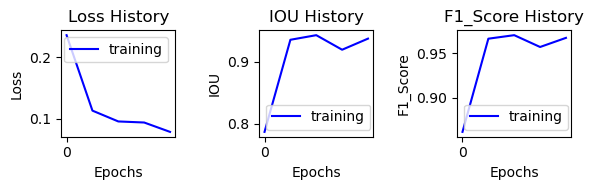

In [5]:
plt.figure(figsize=(6, 2))
plt.subplot(1, 3, 1)
plot_history("Loss History", runner.train_loss_history_stage1)
plt.subplot(1, 3, 2)
plot_history("IOU History", runner.train_IOU_history_stage1)
plt.subplot(1, 3, 3)
plot_history("F1_Score History", runner.train_f1_history_stage1)

plt.tight_layout()
plt.show()

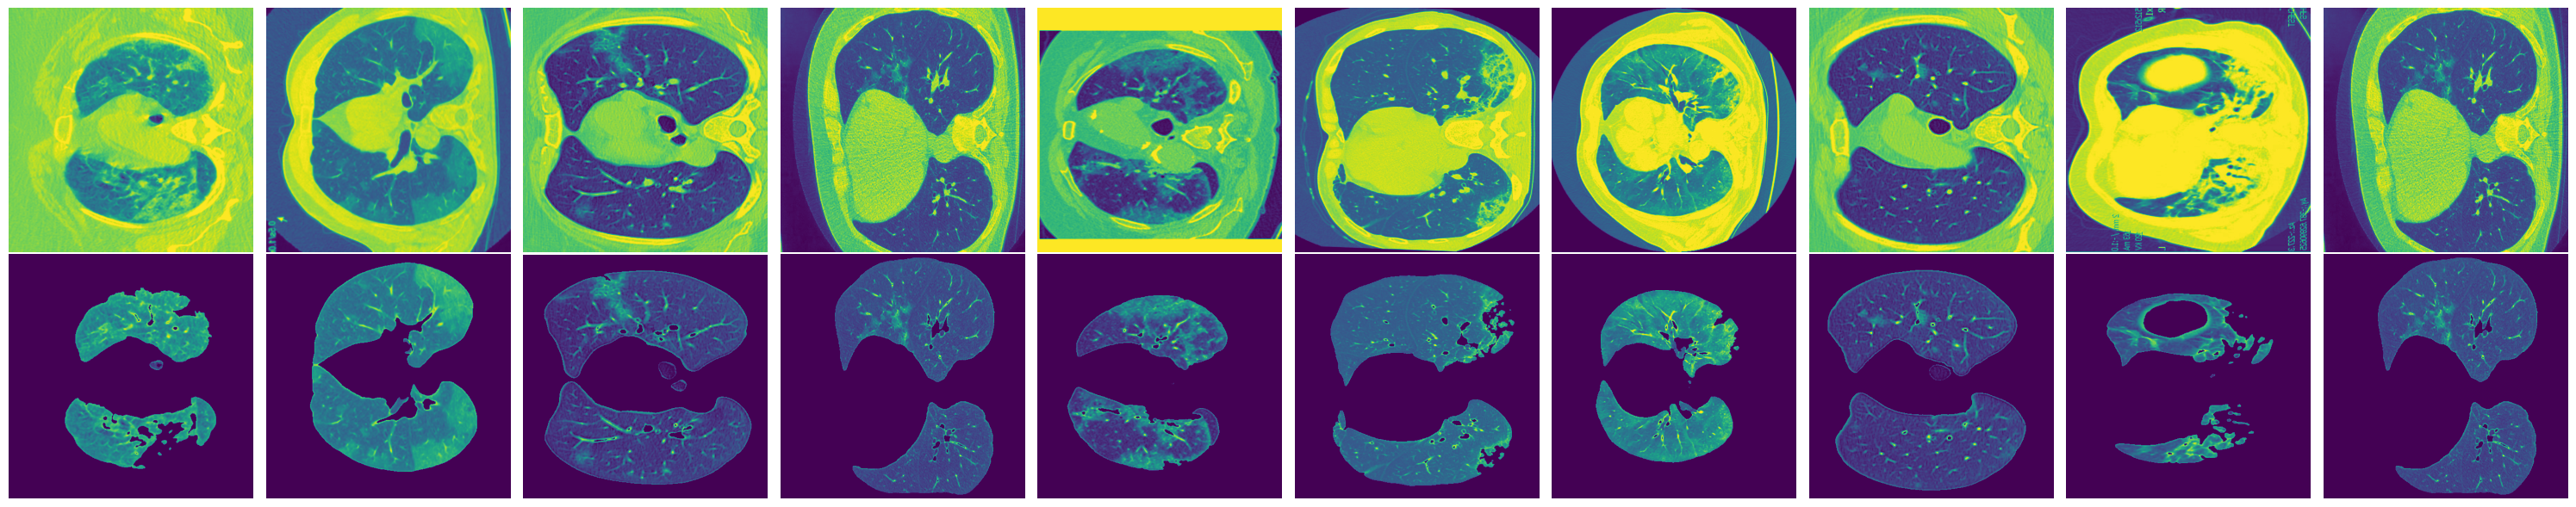

In [6]:
original_images = runner.original_images_val
original_images = np.squeeze(original_images, axis=1)
lung_images = runner.lung_images_val
lung_images = np.squeeze(lung_images, axis=1)
gt = runner.original_masks_val

plot_count = 1
fig = plt.figure(figsize=(30, 6))
for i in np.random.randint(100, size=10):
    plt.subplot(2, 10, plot_count)
    plt.imshow(original_images[i])
    plt.axis('off')

    plt.subplot(2, 10, plot_count+10)
    plt.imshow(lung_images[i])
    plt.axis('off')

    plot_count += 1

plt.tight_layout()
plt.show()

# Cross-validation

k-fold cross-validation is done only on stages 2 and 3 because stage 1 is already good enough.

In [7]:
# Cross-validation

runner.crossval_epoch(num_epochs=num_epochs, load_from_disk=False)

# External Validation

In [ ]:
# Stages 2 and 3 (Only runs with U-Net for now)

runner.run_training_loop_stage2_3(num_epochs=num_epochs, load_from_disk=False)

Epoch:1 Train Loss:2.7709 Val Loss: 2.6967 Train IOU: 0.0912 Validation IOU: 0.0000 Train F1 Score: 0.1666 Validation F1 Score: 0.0000
Epoch:2 Train Loss:2.7393 Val Loss: 2.6517 Train IOU: 0.0866 Validation IOU: 0.0269 Train F1 Score: 0.1591 Validation F1 Score: 0.0519


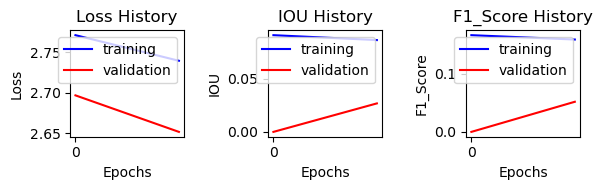

In [ ]:
plt.figure(figsize=(6, 2))
plt.subplot(1, 3, 1)
plot_history("Loss History", runner.train_loss_history, runner.validation_loss_history)
plt.subplot(1, 3, 2)
plot_history("IOU History", runner.train_IOU_history, runner.validation_IOU_history)
plt.subplot(1, 3, 3)
plot_history("F1_Score History", runner.train_f1_history, runner.validation_f1_history)

plt.tight_layout()
plt.show()

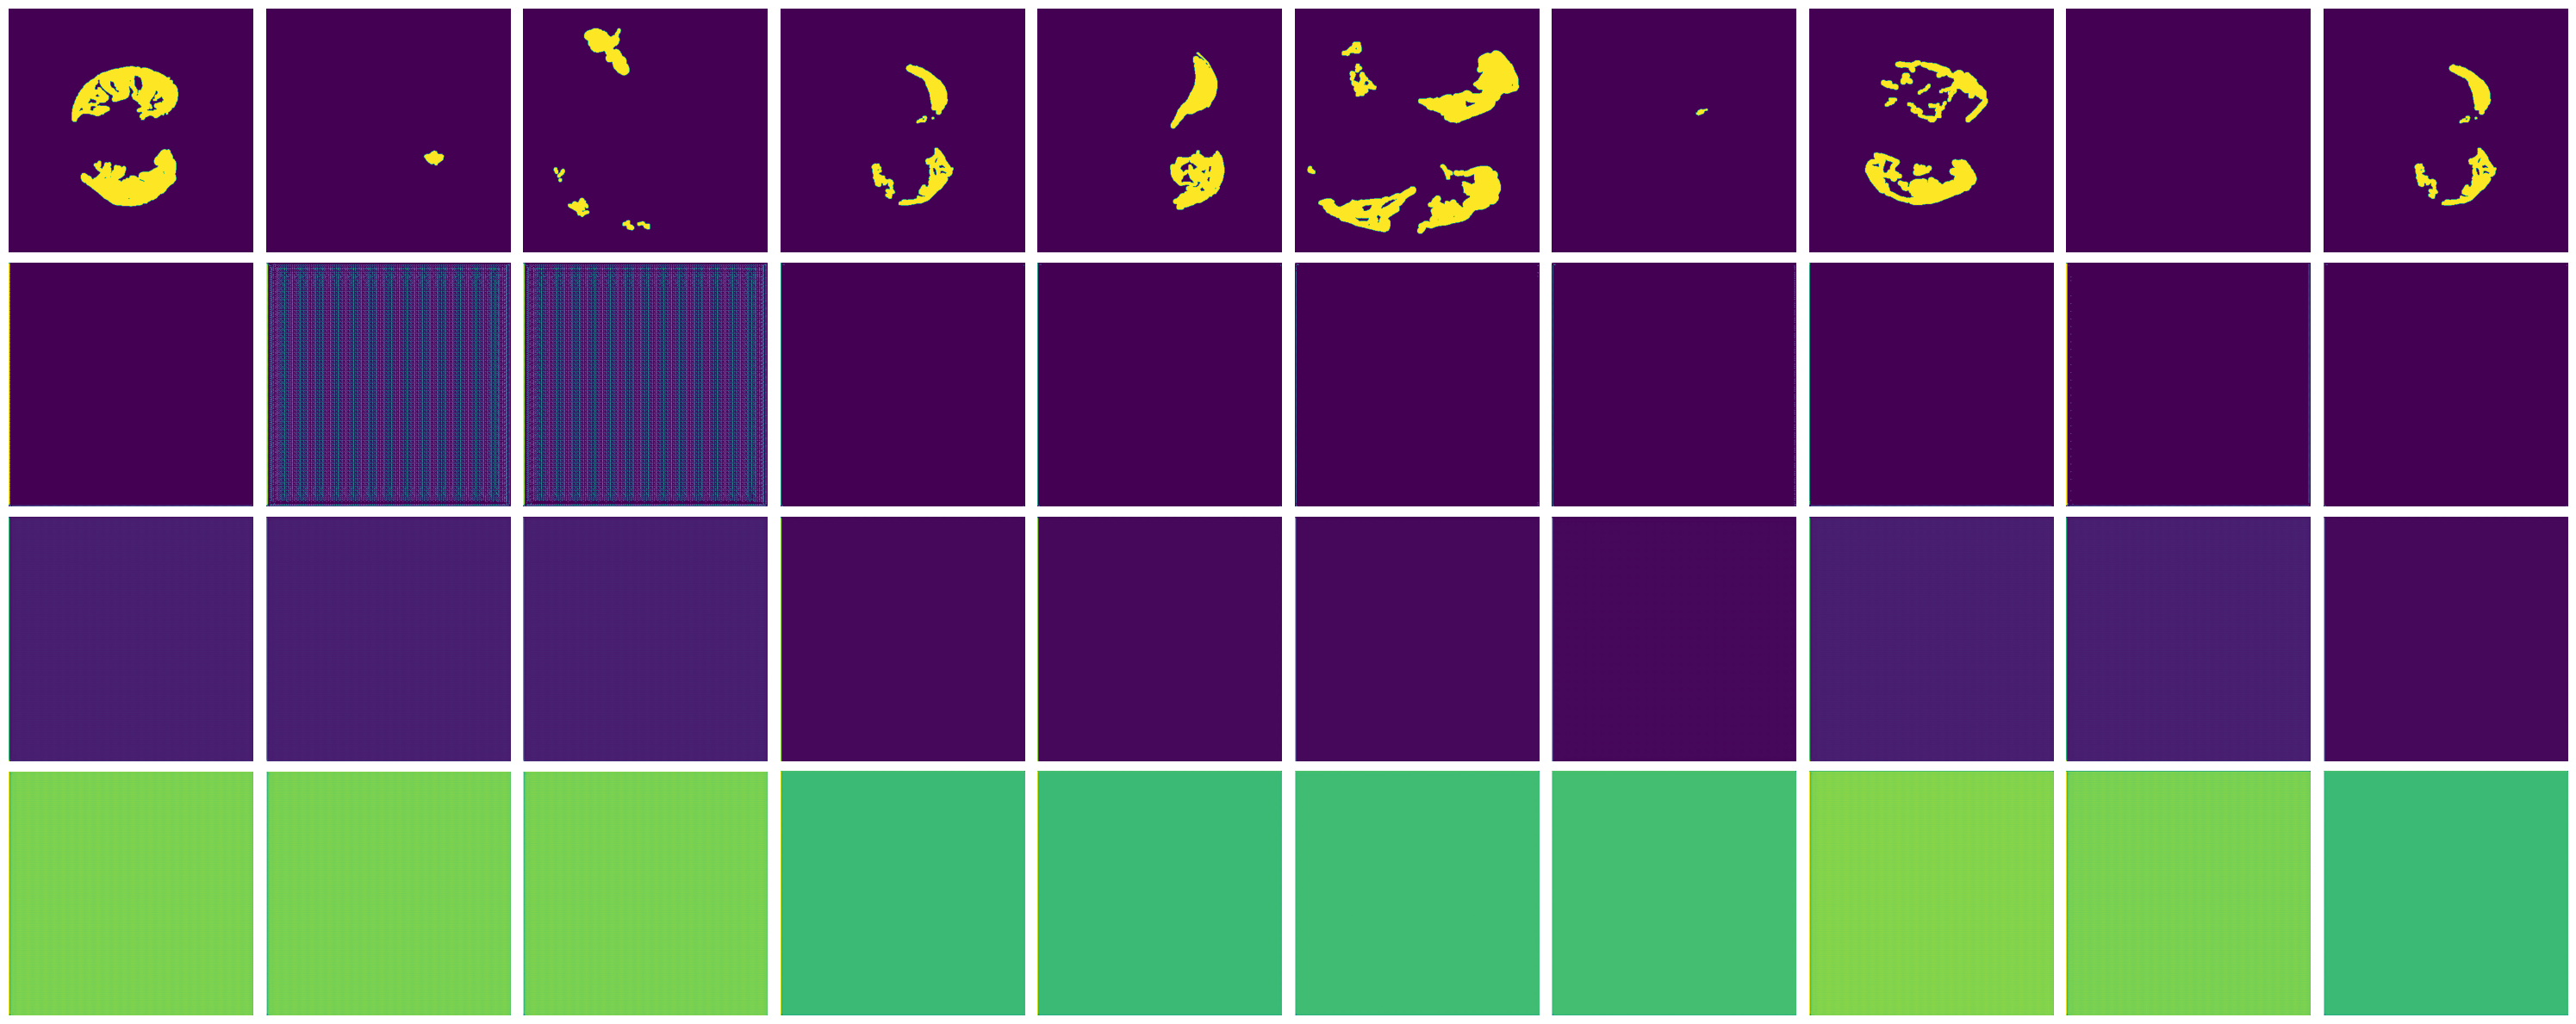

In [ ]:

prediction = runner.predictions_val
sam_var = runner.var
pred_ent = runner.pred_ent

plot_count = 1
fig = plt.figure(figsize=(30, 12))
for i in np.random.randint(100, size=10):
    plt.subplot(4, 10, plot_count)
    plt.imshow(gt[i])
    plt.axis('off')

    plt.subplot(4, 10, plot_count+10)
    plt.imshow(prediction[i])
    plt.axis('off')

    plt.subplot(4, 10, plot_count+20)
    plt.imshow(sam_var[i])
    plt.axis('off')

    plt.subplot(4, 10, plot_count+30)
    plt.imshow(pred_ent[i])
    plt.axis('off')
    
    plot_count += 1

plt.tight_layout()
plt.show()


# Predictivity Plot

Take the last F1 score and IOU from each fold and average them. Take the best F1 score and IOU values of the external validation set.

In [ ]:
k_fold_f1_values = np.array(runner.validation_f1_history_cross)
avg_k_f1 = k_fold_f1_values.mean(axis=0)[-1]
k_fold_IOU_values = np.array(runner.validation_IOU_history_cross)
avg_k_IOU = k_fold_IOU_values.mean(axis=0)[-1]

Text(0, 0.5, 'External Validation')

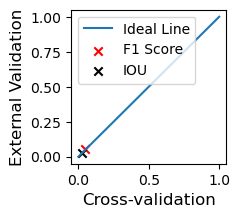

In [ ]:
x_axis = [0, 1]
y_axis = [0, 1]
plt.figure(figsize=(2, 2))
plt.plot(x_axis, y_axis, label='Ideal Line')
plt.scatter(avg_k_f1, runner.best_f1, marker='x', c='red', label='F1 Score')
plt.scatter(avg_k_IOU, runner.best_IOU, marker='x', c='black', label='IOU')

plt.legend()
plt.xlabel('Cross-validation', fontsize=12)
plt.ylabel('External Validation', fontsize=12)